In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
from scipy import stats

In [6]:
!pip install pulp
import pulp

     |████████████████████████████████| 14.2 MB 6.1 MB/s 


## Loading Data

In [7]:
dfDemands = pd.read_csv("drive/MyDrive/Colab Notebooks/ComfortHealth Case Study/demands.csv")
dfDemands.head()

,Year,Region,Demand
0,2012,Downtown Toronto,249581
1,2012,East York,172730
2,2012,Etobicoke,285764
3,2012,Mississauga East,255427
4,2012,North Toronto,263276


In [8]:
dfDistances = pd.read_csv("drive/MyDrive/Colab Notebooks/ComfortHealth Case Study/distances.csv")
dfDistances.head()

,Center,Region,Distance
0,Center A,Downtown Toronto,25.77
1,Center A,East York,2.24
2,Center A,Etobicoke,25.72
3,Center A,Mississauga East,28.65
4,Center A,North Toronto,11.64


In [9]:
dfCenters = pd.read_csv("drive/MyDrive/Colab Notebooks/ComfortHealth Case Study/centers.csv")
dfCenters

,Center,Opening Costs,Operating Costs,Num MPs,Maximum capacity
0,Center A,0,275000,215,5000000
1,Center B,0,275000,125,5000000
2,Center C,0,275000,100,5000000
3,Center D,0,285000,120,5000000
4,Center E,250000,125000,0,5000000
5,Center F,100000,175000,0,5000000


## Self-Defined Functions

In [10]:
def printTable(xvar):

  """
  Demand met (in hours) for the different zones for each center and year.
  xvar: decision variable for demand (in hours)
  """
  
  resultDict = {'Year':[], 'Center':[], 'Region':[], 'Served':[]}

  n = 0
  for t in periods:
    for i in depots:    
      for j in zones:
        resultDict['Center'].append(i)
        resultDict['Year'].append(t)
        resultDict['Region'].append(j)
        resultDict['Served'].append(xvar[(i,j,t)].varValue)
        n+=1

  dfResult = pd.DataFrame(resultDict, index=range(n))
  dfResult = dfResult.pivot(index=['Year', 'Region'], columns=['Center'], values=['Served'])

  return dfResult

In [11]:
def printTable2(wvar):
  
  """
  Health professionals' allocation among the centers for each year.
  wvar: decision variable for the total number of workers at a center
  """
  
  resultDict = {'Year':[], 'Center':[], 'Total Health Professionals':[]}

  n = 0
  for t in periods:
    for i in depots:   
        resultDict['Center'].append(i)
        resultDict['Year'].append(t)
        resultDict['Total Health Professionals'].append(int(wvar[(i,t)].varValue))
        n+=1

  dfResult = pd.DataFrame(resultDict, index=range(n))
  dfResult = dfResult.pivot(index=['Year'], columns=['Center'], values=['Total Health Professionals'])

  return dfResult

In [12]:
def printTable3(hvar):
  
  """
  New health professional hires for the centers for each year.
  hvar: decision variable for the number of workers hired at a center
  """
  
  resultDict = {'Year':[], 'Center':[], 'New Hires':[]}

  n = 0
  for t in periods:
    for i in depots:   
        resultDict['Center'].append(i)
        resultDict['Year'].append(t)
        resultDict['New Hires'].append(int(hvar[(i,t)].varValue))
        n+=1

  dfResult = pd.DataFrame(resultDict, index=range(n))
  dfResult = dfResult.pivot(index=['Year'], columns=['Center'], values=['New Hires'])

  return dfResult

## Forecasting Demand for 2022 - 2024

In [13]:
dfDemands.groupby(by='Region')['Demand'].agg(['mean', 'min', 'max'])

,mean,min,max
Region,,,
Downtown Toronto,313634.1,249581,387003
East York,217075.1,172730,268068
Etobicoke,360431.0,285764,445369
Mississauga East,321349.3,255427,395768
North Toronto,330098.3,263276,406148
North York,400108.9,316579,494386
Scarborough East,352482.6,281067,433845


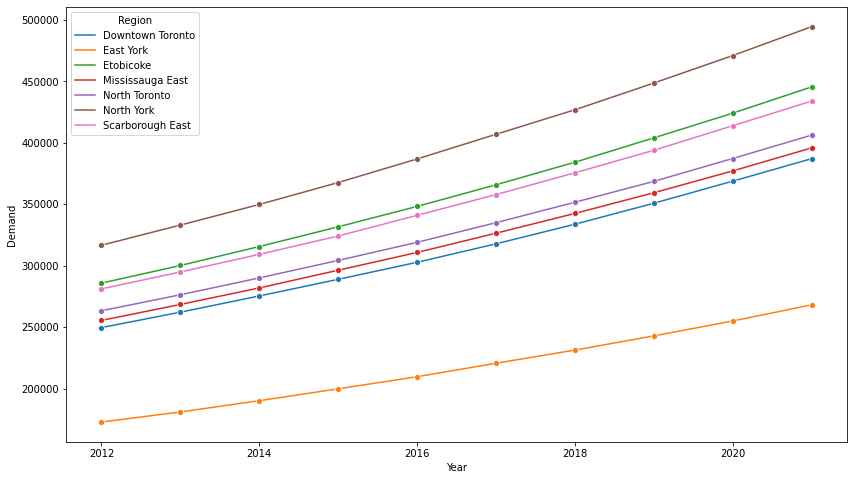

In [14]:
plt.figure(figsize=(14,8))
sns.lineplot(data=dfDemands, x='Year', y='Demand', hue='Region', marker='o')
plt.show()

In [15]:
dictForecast = {'Year':[], 'Region':[], 'Demand':[]}

for region in dfDemands['Region'].unique():
  dfSubset = dfDemands[dfDemands['Region'] == region].copy()
  dfSubset.drop('Region', axis=1, inplace=True)
  X = dfSubset['Year'].values.reshape((-1,1))
  y = dfSubset['Demand'].values
  linReg = LinearRegression().fit(X, y)

  for year in np.arange(2022, 2025):
    forecast = linReg.predict([[year]])
    dictForecast['Year'].append(year)
    dictForecast['Region'].append(region)
    dictForecast['Demand'].append(int(np.floor(forecast[0])))

In [16]:
dfForecast = pd.DataFrame.from_dict(dictForecast)
dfForecast.head()

,Year,Region,Demand
0,2022,Downtown Toronto,397295
1,2023,Downtown Toronto,412506
2,2024,Downtown Toronto,427718
3,2022,East York,275250
4,2023,East York,285828


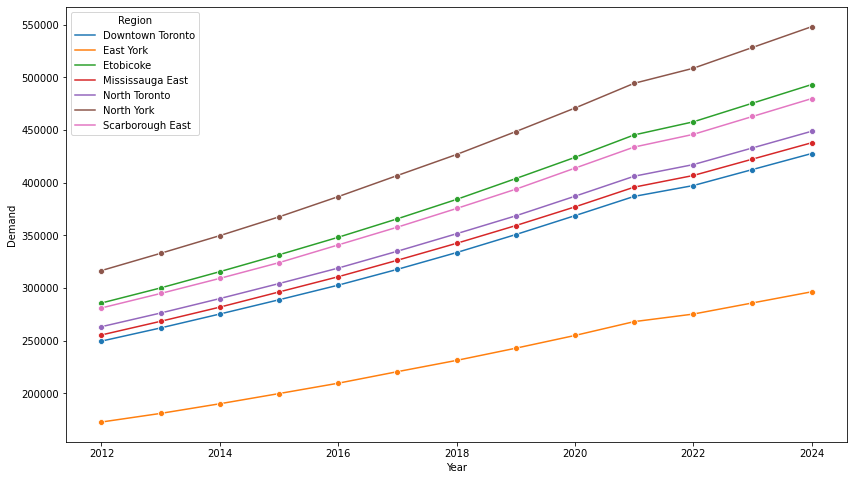

In [17]:
dfAll = pd.concat([dfDemands, dfForecast])
dfAll.reset_index(inplace=True)

plt.figure(figsize=(14,8))
sns.lineplot(data=dfAll, x='Year', y='Demand', hue='Region', marker='o')
plt.show()

## Model 1: Year-Specific, No Hiring (2022)

#### Data Preparation

In [18]:
dfDemands22 = dfForecast[dfForecast['Year'] == 2022].copy()
dfDemands22.drop('Year', axis=1, inplace=True)
dfDemands22.set_index(['Region'], inplace=True)

dfCenters.set_index(['Center'], inplace=True)

In [19]:
dfDemands22

,Demand
Region,
Downtown Toronto,397295
East York,275250
Etobicoke,457808
Mississauga East,406851
North Toronto,417190
North York,508686
Scarborough East,445900


#### Sets

In [20]:
# Centers
depots = list(dfCenters.index)
numdepots = len(depots)

In [21]:
# Regions
zones = list(dfDemands['Region'].unique())
numzones = len(zones)

#### Parameters

In [22]:
# Demand in each zone (dictionary)
zonedemand = {}
for j in zones:    
  zonedemand[j] = float(dfDemands22.loc[j]["Demand"])

zonedemand

{'Downtown Toronto': 397295.0,
 'East York': 275250.0,
 'Etobicoke': 457808.0,
 'Mississauga East': 406851.0,
 'North Toronto': 417190.0,
 'North York': 508686.0,
 'Scarborough East': 445900.0}

In [23]:
# Total workers (dictionary)
total_workers = dfCenters['Num MPs'].sum()
total_workers

560

In [24]:
# Depot capacities (dictionary)
depotcapacity = {}
for i in depots:
  depotcapacity[i] = int(dfCenters.loc[i]["Maximum capacity"])

depotcapacity

{'Center A': 5000000,
 'Center B': 5000000,
 'Center C': 5000000,
 'Center D': 5000000,
 'Center E': 5000000,
 'Center F': 5000000}

In [25]:
# Depot costs: opening (dictionary)
depotcost_opening = {}

for i in depots:
  depotcost_opening[i] = float(dfCenters.loc[i]["Opening Costs"])

depotcost_opening

{'Center A': 0.0,
 'Center B': 0.0,
 'Center C': 0.0,
 'Center D': 0.0,
 'Center E': 250000.0,
 'Center F': 100000.0}

In [26]:
# Depot costs: operating (dictionary)
depotcost_operating = {}

for i in depots:
  depotcost_operating[i] = float(dfCenters.loc[i]["Operating Costs"])

depotcost_operating

{'Center A': 275000.0,
 'Center B': 275000.0,
 'Center C': 275000.0,
 'Center D': 285000.0,
 'Center E': 125000.0,
 'Center F': 175000.0}

In [27]:
# Depot-zone costs (dictionary)
depotzonecost = {}
for i in depots:
  for j in zones:
    depotzonecost[(i,j)] = float(dfDistances[(dfDistances["Center"] == i)&(dfDistances["Region"] == j)]["Distance"]*0.25)

depotzonecost

{('Center A', 'Downtown Toronto'): 6.4425,
 ('Center A', 'East York'): 0.56,
 ('Center A', 'Etobicoke'): 6.43,
 ('Center A', 'Mississauga East'): 7.1625,
 ('Center A', 'North Toronto'): 2.91,
 ('Center A', 'North York'): 0.0,
 ('Center A', 'Scarborough East'): 4.94,
 ('Center B', 'Downtown Toronto'): 7.47,
 ('Center B', 'East York'): 4.01,
 ('Center B', 'Etobicoke'): 7.7775,
 ('Center B', 'Mississauga East'): 8.4825,
 ('Center B', 'North Toronto'): 6.2625,
 ('Center B', 'North York'): 5.745,
 ('Center B', 'Scarborough East'): 0.0,
 ('Center C', 'Downtown Toronto'): 4.775,
 ('Center C', 'East York'): 5.6125,
 ('Center C', 'Etobicoke'): 6.7325,
 ('Center C', 'Mississauga East'): 5.395,
 ('Center C', 'North Toronto'): 5.7475,
 ('Center C', 'North York'): 5.13,
 ('Center C', 'Scarborough East'): 3.715,
 ('Center D', 'Downtown Toronto'): 7.47,
 ('Center D', 'East York'): 4.01,
 ('Center D', 'Etobicoke'): 7.7775,
 ('Center D', 'Mississauga East'): 0.0,
 ('Center D', 'North Toronto'): 6.2625,

#### Variables

In [28]:
# Variables: if a depot is opened/allocated
yvar = pulp.LpVariable.dict("y", depots, cat=pulp.LpBinary)

# Variables: amount of demand from each zone allocated to depot, per scenario
xvar = pulp.LpVariable.dict("x", (depots, zones), lowBound=0.0, cat=pulp.LpContinuous)

# Variables: number of workers in a center
wvar = pulp.LpVariable.dict("w", (depots), lowBound=0.0, cat=pulp.LpInteger)

#### Model Initialization

In [29]:
# Initialize model and objective sense
locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

#### Constraints

In [30]:
# Contraint: demand must be satisfied in all scenarios
for j in zones:
  locationModel += pulp.lpSum( [xvar[(i,j)] for i in depots] ) <= zonedemand[j]

for i in depots:        
# Constraint: depot capacities must be observed in all scenarios
  locationModel += pulp.lpSum( [xvar[(i,j)] for j in zones] ) <= depotcapacity[i] * yvar[i]

# Constraint: center capacity is limited by available professionals
  locationModel += pulp.lpSum( [xvar[(i,j)] for j in zones ] ) <= 250 * 6 * wvar[i]

locationModel += pulp.lpSum( [wvar[i] for i in depots] ) <= total_workers

#### Objective Function

In [31]:
# Objective function

rate = 42 # amount reimbursed

# Revenue earned through reimbursement by the governement
obj = pulp.lpSum( [ rate * xvar[(i,j)] for i in depots for j in zones ] )

# Depot allocation costs
# obj -= pulp.lpSum([ depotcost[i] * yvar[i] for i in depots])
obj -= pulp.lpSum([ depotcost_operating[i] for i in ['Center A', 'Center B', 'Center C', 'Center D']] ) 
obj -= pulp.lpSum([ (depotcost_opening[i] + depotcost_operating[i]) * yvar[i] for i in ['Center E', 'Center F'] ])

# Distance costs
obj -= pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j)] for i in depots for j in zones ] )

# Health professional cost
obj -= pulp.lpSum( [ 37.85 * 250 * 6 * wvar[(i)] for i in depots] )

# Add objective to model
locationModel += obj

#### Solution

In [32]:
# Write LP to file 
locationModel.writeLP("locationModel.lp")

# Solve model
locationModel.solve()
print("Status:", pulp.LpStatus[locationModel.status])

Status: Optimal


In [33]:
# Total profit
totalProfit = pulp.value(locationModel.objective)
print("Total profit: " + str(totalProfit))

Total profit: 2376000.0


In [34]:
# Manual check on whether profit matches expected value
(42-37.85)*250*6*560-np.sum(list(depotcost_operating.values()))+3e5

2375999.9999999986

In [35]:
# Solution
for i in depots:
  if yvar[i].varValue >= 1.0:
    print("\n Depot " + str(i) + " is opened")                            
    for j in zones:
      if xvar[(i,j)].varValue > 0.0:
        print("\t\tServes zone " + str(j) + " with a capacity of " + str(int(xvar[(i,j)].varValue)))


 Depot Center A is opened

 Depot Center B is opened
		Serves zone Scarborough East with a capacity of 433500

 Depot Center C is opened

 Depot Center D is opened
		Serves zone Mississauga East with a capacity of 406500


#### Analysis

In [36]:
dfDistances[dfDistances['Center'] == 'Center B']

,Center,Region,Distance
7,Center B,Downtown Toronto,29.88
8,Center B,East York,16.04
9,Center B,Etobicoke,31.11
10,Center B,Mississauga East,33.93
11,Center B,North Toronto,25.05
12,Center B,North York,22.98
13,Center B,Scarborough East,0.00


In [37]:
dfDistances[dfDistances['Center'] == 'Center D']

,Center,Region,Distance
21,Center D,Downtown Toronto,29.88
22,Center D,East York,16.04
23,Center D,Etobicoke,31.11
24,Center D,Mississauga East,0.00
25,Center D,North Toronto,25.05
26,Center D,North York,22.98
27,Center D,Scarborough East,26.78


In [38]:
dfTemp = dfForecast[dfForecast.Year == 2022].sort_values(by='Demand', ascending=False).copy(deep=True)
dfTemp['MPs'] = dfTemp['Demand']/(250 * 6)

In [39]:
dfTemp.sort_values(by='MPs', ascending=True)

,Year,Region,Demand,MPs
3,2022,East York,275250,183.500000
0,2022,Downtown Toronto,397295,264.863333
9,2022,Mississauga East,406851,271.234000
12,2022,North Toronto,417190,278.126667
18,2022,Scarborough East,445900,297.266667
6,2022,Etobicoke,457808,305.205333
15,2022,North York,508686,339.124000


In [40]:
dfDistances[dfDistances.Distance == 0]

,Center,Region,Distance
5,Center A,North York,0.0
13,Center B,Scarborough East,0.0
24,Center D,Mississauga East,0.0
32,Center E,North Toronto,0.0
38,Center F,Mississauga East,0.0


## Model 2: Period-Flow Incorporated, No Hiring (2022 - 2024)

#### Sets

In [41]:
# Centers
depots = list(dfCenters.index)
numdepots = len(depots)

In [42]:
# Regions
zones = list(dfDemands['Region'].unique())
numzones = len(zones)

In [43]:
# Periods
periods = list(dfForecast['Year'].unique())
numperiods = len(periods)

#### Parameters

In [44]:
# Demand in each zone (dictionary)
zonedemand = {}
for t in periods:
  for j in zones:    
    zonedemand[(j,t)] = int(dfForecast[(dfForecast["Year"] == t)&(dfForecast["Region"] == j)]['Demand'])

zonedemand

{('Downtown Toronto', 2022): 397295,
 ('Downtown Toronto', 2023): 412506,
 ('Downtown Toronto', 2024): 427718,
 ('East York', 2022): 275250,
 ('East York', 2023): 285828,
 ('East York', 2024): 296405,
 ('Etobicoke', 2022): 457808,
 ('Etobicoke', 2023): 475512,
 ('Etobicoke', 2024): 493217,
 ('Mississauga East', 2022): 406851,
 ('Mississauga East', 2023): 422397,
 ('Mississauga East', 2024): 437943,
 ('North Toronto', 2022): 417190,
 ('North Toronto', 2023): 433025,
 ('North Toronto', 2024): 448859,
 ('North York', 2022): 508686,
 ('North York', 2023): 528427,
 ('North York', 2024): 548169,
 ('Scarborough East', 2022): 445900,
 ('Scarborough East', 2023): 462885,
 ('Scarborough East', 2024): 479871}

In [45]:
# Total workers (dictionary)
total_workers = dfCenters['Num MPs'].sum()
total_workers

560

In [46]:
# Depot capacities (dictionary)
depotcapacity = {}
for i in depots:
  depotcapacity[i] = int(dfCenters.loc[i]["Maximum capacity"])

depotcapacity

{'Center A': 5000000,
 'Center B': 5000000,
 'Center C': 5000000,
 'Center D': 5000000,
 'Center E': 5000000,
 'Center F': 5000000}

In [47]:
# Depot costs: opening (dictionary)
depotcost_opening = {}

for i in depots:
  depotcost_opening[i] = float(dfCenters.loc[i]["Opening Costs"])

depotcost_opening

{'Center A': 0.0,
 'Center B': 0.0,
 'Center C': 0.0,
 'Center D': 0.0,
 'Center E': 250000.0,
 'Center F': 100000.0}

In [48]:
# Depot costs: operating (dictionary)
depotcost_operating = {}

for i in depots:
  depotcost_operating[i] = float(dfCenters.loc[i]["Operating Costs"])

depotcost_operating

{'Center A': 275000.0,
 'Center B': 275000.0,
 'Center C': 275000.0,
 'Center D': 285000.0,
 'Center E': 125000.0,
 'Center F': 175000.0}

In [49]:
# Operating depots:
y = {}

for depot in depots:
  if depotcost_opening[depot] == 0.0:
    y[depot] = 1
  else:
    y[depot] = 0

y

{'Center A': 1,
 'Center B': 1,
 'Center C': 1,
 'Center D': 1,
 'Center E': 0,
 'Center F': 0}

In [50]:
# Depot-zone costs (dictionary)
depotzonecost = {}
for i in depots:
  for j in zones:
    depotzonecost[(i,j)] = float(dfDistances[(dfDistances["Center"] == i)&(dfDistances["Region"] == j)]["Distance"]*0.25)

depotzonecost

{('Center A', 'Downtown Toronto'): 6.4425,
 ('Center A', 'East York'): 0.56,
 ('Center A', 'Etobicoke'): 6.43,
 ('Center A', 'Mississauga East'): 7.1625,
 ('Center A', 'North Toronto'): 2.91,
 ('Center A', 'North York'): 0.0,
 ('Center A', 'Scarborough East'): 4.94,
 ('Center B', 'Downtown Toronto'): 7.47,
 ('Center B', 'East York'): 4.01,
 ('Center B', 'Etobicoke'): 7.7775,
 ('Center B', 'Mississauga East'): 8.4825,
 ('Center B', 'North Toronto'): 6.2625,
 ('Center B', 'North York'): 5.745,
 ('Center B', 'Scarborough East'): 0.0,
 ('Center C', 'Downtown Toronto'): 4.775,
 ('Center C', 'East York'): 5.6125,
 ('Center C', 'Etobicoke'): 6.7325,
 ('Center C', 'Mississauga East'): 5.395,
 ('Center C', 'North Toronto'): 5.7475,
 ('Center C', 'North York'): 5.13,
 ('Center C', 'Scarborough East'): 3.715,
 ('Center D', 'Downtown Toronto'): 7.47,
 ('Center D', 'East York'): 4.01,
 ('Center D', 'Etobicoke'): 7.7775,
 ('Center D', 'Mississauga East'): 0.0,
 ('Center D', 'North Toronto'): 6.2625,

In [51]:
# Depot workers (dictionary)
depotworkers = {}
for i in depots:
  depotworkers[i] = float(dfCenters.loc[i]["Num MPs"])

depotworkers

{'Center A': 215.0,
 'Center B': 125.0,
 'Center C': 100.0,
 'Center D': 120.0,
 'Center E': 0.0,
 'Center F': 0.0}

#### Variables

In [52]:
# Variables: if a depot is opened/allocated
yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

# Variables: amount of demand from each zone allocated to depot, per scenario
xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

# Worker flow
wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpInteger)

#### Model Initialization

In [53]:
# Initialize model and objective sense
locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

#### Constraints

In [54]:
# Balance of flow constraints

for m in ([2021]+periods):
  locationModel += pulp.lpSum( [ wvar[(i, m)] for i in depots ] ) == (total_workers)

for t in periods:
  for j in zones:
  # Contraint: demand must be satisfied in all scenarios
    locationModel += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) <= zonedemand[(j,t)])

  for i in ['Center A', 'Center B', 'Center C', 'Center D']:
    locationModel += ( yvar[(i, 2021)] == 1 )
    locationModel += ( yvar[(i, t)] == 1 )
  
  for i in ['Center E', 'Center F']: 
    locationModel += ( yvar[(i, 2021)] == 0 )
    locationModel += ( yvar[(i, t)] >= yvar[(i, t-1)] )

  for i in depots:
   # Constraint: depot capacities must be observed in all scenarios
    locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

  # Worker flow
    locationModel += (wvar[(i,t)] == wvar[(i,t-1)])

  # Capacity limited by workers
    locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= 250 * 6 * wvar[(i,t)]

#### Objective Function

In [55]:
# Objective function

rate = 42 # amount reimbursed

# Depot allocation costs
obj = -( pulp.lpSum([ depotcost_opening[i] * yvar[(i,2024)] for i in depots] ) )

for t in periods:
  
  # Revenue earned through reimbursement by the governement
  obj += pulp.lpSum( [ rate * xvar[(i,j,t)] for i in depots for j in zones ] )

  # Distance costs
  obj -= pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

  # Depot operating cost
  obj -= pulp.lpSum( [ depotcost_operating[i] * yvar[(i,t)] for i in depots] )

  # Health professional cost
  obj -= pulp.lpSum( [ (37.85 * 250 * 6) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

# Add objective to model
locationModel += obj

#### Solution

In [56]:
# Write LP to file 
locationModel.writeLP("locationModel.lp")

# Solve model
locationModel.solve()
print("Status:", pulp.LpStatus[locationModel.status])

Status: Optimal


In [57]:
# Total profit
totalProfit = pulp.value(locationModel.objective)
print("Total profit: " + str(totalProfit))

Total profit: 4723578.750000013


In [58]:
for t in ([2021]+periods):
  print('\n', t)
  for i in depots:
    val = yvar[(i,t)].varValue
    if val == 1.0:
      flag = 'Open'
    else:
      flag = 'Closed'
    print('\t', i, '|', flag)


 2021
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Closed
	 Center F | Closed

 2022
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Closed
	 Center F | Closed

 2023
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Closed
	 Center F | Closed

 2024
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Closed
	 Center F | Closed


In [59]:
for t in periods:
  print('\n', t)
  for i in depots:
    print('\t', i, '| Total MPs:', int(np.floor(wvar[(i,t)].varValue)))


 2022
	 Center A | Total MPs: 339
	 Center B | Total MPs: 221
	 Center C | Total MPs: 0
	 Center D | Total MPs: 0
	 Center E | Total MPs: 0
	 Center F | Total MPs: 0

 2023
	 Center A | Total MPs: 339
	 Center B | Total MPs: 221
	 Center C | Total MPs: 0
	 Center D | Total MPs: 0
	 Center E | Total MPs: 0
	 Center F | Total MPs: 0

 2024
	 Center A | Total MPs: 339
	 Center B | Total MPs: 221
	 Center C | Total MPs: 0
	 Center D | Total MPs: 0
	 Center E | Total MPs: 0
	 Center F | Total MPs: 0


In [60]:
personnel = {2022:0, 2023:0, 2024:0}

for t in periods:
  for i in depots:
    personnel[t] += wvar[(i,t)].varValue*250*6

personnel

{2022: 840000.0, 2023: 840000.0, 2024: 840000.0}

In [61]:
# Solution
for t in periods:
  print('\n', t)
  for i in depots:
    if yvar[(i,t)].varValue >= 1.0:
      print("\t Depot " + str(i) + " is opened")                            
      for j in zones:
        if xvar[(i,j,t)].varValue > 0.0:
          print("\t\tServes zone " + str(j) + " with a capacity of " + str(int(xvar[(i,j,t)].varValue)))


 2022
	 Depot Center A is opened
		Serves zone North York with a capacity of 508500
	 Depot Center B is opened
		Serves zone Scarborough East with a capacity of 331500
	 Depot Center C is opened
	 Depot Center D is opened

 2023
	 Depot Center A is opened
		Serves zone North York with a capacity of 508500
	 Depot Center B is opened
		Serves zone Scarborough East with a capacity of 331500
	 Depot Center C is opened
	 Depot Center D is opened

 2024
	 Depot Center A is opened
		Serves zone North York with a capacity of 508500
	 Depot Center B is opened
		Serves zone Scarborough East with a capacity of 331500
	 Depot Center C is opened
	 Depot Center D is opened


#### Analysis

In [62]:
dfDistances.groupby(by='Region').mean().sort_values(by='Distance')

,Distance
Region,
Scarborough East,17.383333
Mississauga East,17.468333
North Toronto,17.563333
North York,17.795000
East York,18.066667
Downtown Toronto,21.638333
Etobicoke,27.285000


In [63]:
dfDistances[(dfDistances.Region == 'Scarborough East')|(dfDistances.Region == 'North York')].\
sort_values(by='Distance')

,Center,Region,Distance
5,Center A,North York,0.00
13,Center B,Scarborough East,0.00
33,Center E,North York,11.64
20,Center C,Scarborough East,14.86
41,Center F,Scarborough East,17.01
6,Center A,Scarborough East,19.76
19,Center C,North York,20.52
12,Center B,North York,22.98
26,Center D,North York,22.98
34,Center E,Scarborough East,25.89


In [64]:
printTable(xvar)

Served                                              
Center                 Center A  Center B Center C Center D Center E Center F
Year Region                                                                  
2022 Downtown Toronto       0.0       0.0      0.0      0.0      0.0      0.0
     East York              0.0       0.0      0.0      0.0      0.0      0.0
     Etobicoke              0.0       0.0      0.0      0.0      0.0      0.0
     Mississauga East       0.0       0.0      0.0      0.0      0.0      0.0
     North Toronto          0.0       0.0      0.0      0.0      0.0      0.0
     North York        508500.0       0.0      0.0      0.0      0.0      0.0
     Scarborough East       0.0  331500.0      0.0      0.0      0.0      0.0
2023 Downtown Toronto       0.0       0.0      0.0      0.0      0.0      0.0
     East York              0.0       0.0      0.0      0.0      0.0      0.0
     Etobicoke              0.0       0.0      0.0      0.0      0.0      0.0
     Mississauga East       0.0       0.0      0.0      0.0      0.0      0.0
     North Toronto          0.0       0.0      0.0      0.0      0.0      0.0
     North York        508500.0       0.0      0.0      0.0      0.0      0.0
     Scarborough East       0.0  331500.0      0.0      0.0      0.0      0.0
2024 Downtown Toronto       0.0       0.0      0.0      0.0      0.0      0.0
     East York              0.0       0.0      0.0      0.0      0.0      0.0
     Etobicoke              0.0       0.0      0.0      0.0      0.0      0.0
     Mississauga East       0.0       0.0      0.0      0.0      0.0      0.0
     North Toronto          0.0       0.0      0.0      0.0      0.0      0.0
     North York        508500.0       0.0      0.0      0.0      0.0      0.0
     Scarborough East       0.0  331500.0      0.0      0.0      0.0      0.0

In [65]:
printTable2(wvar)

Total Health Professionals                                             
Center                   Center A Center B Center C Center D Center E Center F
Year                                                                          
2022                          339      221        0        0        0        0
2023                          339      221        0        0        0        0
2024                          339      221        0        0        0        0

In [66]:
# Percent of total demand met for North York
508500*3/(dfForecast[dfForecast.Region == 'North York']['Demand'].sum())

0.9622893592433397

In [67]:
# Percent of total demand met for Scarborough East
331500*3/(dfForecast[dfForecast.Region == 'Scarborough East']['Demand'].sum())

0.716160085723174

In [68]:
# Percent of total demand met
((331500+508500)*3)/(dfForecast['Demand'].sum())

0.2780922255345606

## Model 3, Case I: Period-Flow & Hiring Incorporated (2022 - 2024), Maximizing Profits

#### Sets

In [69]:
# Centers
depots = list(dfCenters.index)
numdepots = len(depots)

In [70]:
# Regions
zones = list(dfDemands['Region'].unique())
numzones = len(zones)

In [71]:
# Periods
periods = list(dfForecast['Year'].unique())
numperiods = len(periods)

#### Parameters

In [72]:
# Demand in each zone (dictionary)
zonedemand = {}
for t in periods:
  for j in zones:    
    zonedemand[(j,t)] = int(dfForecast[(dfForecast["Year"] == t)&(dfForecast["Region"] == j)]['Demand'])

zonedemand

{('Downtown Toronto', 2022): 397295,
 ('Downtown Toronto', 2023): 412506,
 ('Downtown Toronto', 2024): 427718,
 ('East York', 2022): 275250,
 ('East York', 2023): 285828,
 ('East York', 2024): 296405,
 ('Etobicoke', 2022): 457808,
 ('Etobicoke', 2023): 475512,
 ('Etobicoke', 2024): 493217,
 ('Mississauga East', 2022): 406851,
 ('Mississauga East', 2023): 422397,
 ('Mississauga East', 2024): 437943,
 ('North Toronto', 2022): 417190,
 ('North Toronto', 2023): 433025,
 ('North Toronto', 2024): 448859,
 ('North York', 2022): 508686,
 ('North York', 2023): 528427,
 ('North York', 2024): 548169,
 ('Scarborough East', 2022): 445900,
 ('Scarborough East', 2023): 462885,
 ('Scarborough East', 2024): 479871}

In [73]:
# Total workers (dictionary)
total_workers = dfCenters['Num MPs'].sum()
total_workers

560

In [74]:
# Depot capacities (dictionary)
depotcapacity = {}
for i in depots:
  depotcapacity[i] = int(dfCenters.loc[i]["Maximum capacity"])

depotcapacity

{'Center A': 5000000,
 'Center B': 5000000,
 'Center C': 5000000,
 'Center D': 5000000,
 'Center E': 5000000,
 'Center F': 5000000}

In [75]:
# Depot costs: opening (dictionary)
depotcost_opening = {}

for i in depots:
  depotcost_opening[i] = float(dfCenters.loc[i]["Opening Costs"])

depotcost_opening

{'Center A': 0.0,
 'Center B': 0.0,
 'Center C': 0.0,
 'Center D': 0.0,
 'Center E': 250000.0,
 'Center F': 100000.0}

In [76]:
# Depot costs: operating (dictionary)
depotcost_operating = {}

for i in depots:
  depotcost_operating[i] = float(dfCenters.loc[i]["Operating Costs"])

depotcost_operating

{'Center A': 275000.0,
 'Center B': 275000.0,
 'Center C': 275000.0,
 'Center D': 285000.0,
 'Center E': 125000.0,
 'Center F': 175000.0}

In [77]:
# Operating depots:
y = {}

for depot in depots:
  if depotcost_opening[depot] == 0.0:
    y[depot] = 1
  else:
    y[depot] = 0

y

{'Center A': 1,
 'Center B': 1,
 'Center C': 1,
 'Center D': 1,
 'Center E': 0,
 'Center F': 0}

In [78]:
# Depot-zone costs (dictionary)
depotzonecost = {}
for i in depots:
  for j in zones:
    depotzonecost[(i,j)] = float(dfDistances[(dfDistances["Center"] == i)&(dfDistances["Region"] == j)]["Distance"]*0.25)

depotzonecost

{('Center A', 'Downtown Toronto'): 6.4425,
 ('Center A', 'East York'): 0.56,
 ('Center A', 'Etobicoke'): 6.43,
 ('Center A', 'Mississauga East'): 7.1625,
 ('Center A', 'North Toronto'): 2.91,
 ('Center A', 'North York'): 0.0,
 ('Center A', 'Scarborough East'): 4.94,
 ('Center B', 'Downtown Toronto'): 7.47,
 ('Center B', 'East York'): 4.01,
 ('Center B', 'Etobicoke'): 7.7775,
 ('Center B', 'Mississauga East'): 8.4825,
 ('Center B', 'North Toronto'): 6.2625,
 ('Center B', 'North York'): 5.745,
 ('Center B', 'Scarborough East'): 0.0,
 ('Center C', 'Downtown Toronto'): 4.775,
 ('Center C', 'East York'): 5.6125,
 ('Center C', 'Etobicoke'): 6.7325,
 ('Center C', 'Mississauga East'): 5.395,
 ('Center C', 'North Toronto'): 5.7475,
 ('Center C', 'North York'): 5.13,
 ('Center C', 'Scarborough East'): 3.715,
 ('Center D', 'Downtown Toronto'): 7.47,
 ('Center D', 'East York'): 4.01,
 ('Center D', 'Etobicoke'): 7.7775,
 ('Center D', 'Mississauga East'): 0.0,
 ('Center D', 'North Toronto'): 6.2625,

In [79]:
# Depot workers (dictionary)
depotworkers = {}
for i in depots:
  depotworkers[i] = float(dfCenters.loc[i]["Num MPs"])

depotworkers

{'Center A': 215.0,
 'Center B': 125.0,
 'Center C': 100.0,
 'Center D': 120.0,
 'Center E': 0.0,
 'Center F': 0.0}

#### Variables

In [80]:
# Variables: if a depot is opened/allocated
yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

# Variables: amount of demand from each zone allocated to depot, per scenario
xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

# Worker flow
wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

# New hires
hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

#### Model Initialization

In [81]:
# Initialize model and objective sense
locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

#### Constraints

In [82]:
# Balance of flow constraints

for t in periods:

  for j in zones:
  # Contraint: demand must be satisfied in all scenarios
    locationModel += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) <= zonedemand[(j,t)])

  for i in ['Center A', 'Center B', 'Center C', 'Center D']:
    locationModel += ( yvar[(i, 2021)] == 1 )
    locationModel += ( yvar[(i, t)] == 1 )
  
  for i in ['Center E', 'Center F']: 
    locationModel += ( yvar[(i, 2021)] == 0 )
    locationModel += ( yvar[(i, t)] >= yvar[(i, t-1)] )

  for i in depots:
 
  # Constraint: depot capacities must be observed in all scenarios
    locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

  # Worker flow
    if t == 2022:
      locationModel += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_workers)

    numworkers = wvar[(i,t-1)] + hvar[(i,t)]
    locationModel += (wvar[(i,t)] == numworkers)

  # Capacity limited by workers
    locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= 250 * 6 * wvar[(i,t)]

  # Maximum number of hires
    locationModel += pulp.lpSum( hvar[(i,t)] ) <= 300

#### Objective Function

In [83]:
# Objective function

rate = 42 # amount reimbursed

# Depot allocation costs
obj = -( pulp.lpSum([ depotcost_opening[i] * yvar[(i,2024)] for i in depots] ) )

for t in periods:

  # Revenue earned through reimbursement by the governement
  obj += pulp.lpSum( [ rate * xvar[(i,j,t)] for i in depots for j in zones ] )
  
  # Distance costs
  obj -= pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

  obj -= pulp.lpSum([ depotcost_operating[i] * yvar[(i,t)] for i in depots] )

  # Workers' pay
  obj -= pulp.lpSum( [ (37.85 * 250 * 6) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

  # Hiring costs
  obj -= pulp.lpSum( [ 15000 * hvar[(i,t)] for i in depots ] )

# Add objective to model
locationModel += obj

#### Solution

In [84]:
# Write LP to file 
locationModel.writeLP("locationModel.lp")

# Solve model
locationModel.solve()
print("Status:", pulp.LpStatus[locationModel.status])

Status: Optimal


In [85]:
# Total profit
totalProfit = pulp.value(locationModel.objective)
print("Total profit: " + str(totalProfit))

Total profit: 4723578.750000004


In [86]:
for t in ([2021]+periods):
  print('\n', t)
  for i in depots:
    val = yvar[(i,t)].varValue
    if val == 1.0:
      flag = 'Open'
    else:
      flag = 'Closed'
    print('\t', i, '|', flag)


 2021
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Closed
	 Center F | Closed

 2022
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Closed
	 Center F | Closed

 2023
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Closed
	 Center F | Closed

 2024
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Closed
	 Center F | Closed


In [87]:
for t in periods:
  print('\n', t)
  for i in depots:
    print('\t', i, '| Total MPs:', int(np.floor(wvar[(i,t)].varValue)), '| New Hires:', int(np.floor(hvar[(i,t)].varValue)))


 2022
	 Center A | Total MPs: 339 | New Hires: 0
	 Center B | Total MPs: 220 | New Hires: 0
	 Center C | Total MPs: 0 | New Hires: 0
	 Center D | Total MPs: 0 | New Hires: 0
	 Center E | Total MPs: 0 | New Hires: 0
	 Center F | Total MPs: 0 | New Hires: 0

 2023
	 Center A | Total MPs: 339 | New Hires: 0
	 Center B | Total MPs: 220 | New Hires: 0
	 Center C | Total MPs: 0 | New Hires: 0
	 Center D | Total MPs: 0 | New Hires: 0
	 Center E | Total MPs: 0 | New Hires: 0
	 Center F | Total MPs: 0 | New Hires: 0

 2024
	 Center A | Total MPs: 339 | New Hires: 0
	 Center B | Total MPs: 220 | New Hires: 0
	 Center C | Total MPs: 0 | New Hires: 0
	 Center D | Total MPs: 0 | New Hires: 0
	 Center E | Total MPs: 0 | New Hires: 0
	 Center F | Total MPs: 0 | New Hires: 0


In [88]:
hiring = 0
salaries = 0 
personnel = 0

for t in periods:
  for i in depots:
    hiring += hvar[(i,t)].varValue*15000
    salaries += wvar[(i,t)].varValue*37.85*250*6
    personnel += wvar[(i,t)].varValue

In [89]:
personnel = {2022:0, 2023:0, 2024:0}

for t in periods:
  for i in depots:
    personnel[t] += wvar[(i,t)].varValue*250*6

personnel

{2022: 840000.0, 2023: 840000.0, 2024: 840000.0}

In [90]:
dfForecast.groupby('Year').sum()

,Demand
Year,
2022,2908980
2023,3020580
2024,3132182


In [91]:
# Solution
for t in periods:
  print('\n', t)
  for i in depots:
    if yvar[(i,t)].varValue >= 1.0:
      print("\t Depot " + str(i) + " is opened")                            
      for j in zones:
        if xvar[(i,j,t)].varValue > 0.0:
          print("\t\tServes zone " + str(j) + " with a capacity of " + str(int(xvar[(i,j,t)].varValue)))


 2022
	 Depot Center A is opened
		Serves zone North York with a capacity of 508686
	 Depot Center B is opened
		Serves zone Scarborough East with a capacity of 331314
	 Depot Center C is opened
	 Depot Center D is opened

 2023
	 Depot Center A is opened
		Serves zone North York with a capacity of 508686
	 Depot Center B is opened
		Serves zone Scarborough East with a capacity of 331314
	 Depot Center C is opened
	 Depot Center D is opened

 2024
	 Depot Center A is opened
		Serves zone North York with a capacity of 508686
	 Depot Center B is opened
		Serves zone Scarborough East with a capacity of 331314
	 Depot Center C is opened
	 Depot Center D is opened


In [92]:
# Solution
for t in periods:
  print('\n', t)
  for i in depots:
    if yvar[(i,t)].varValue >= 1.0:
      print("\t Depot " + str(i) + " is opened")                            
      for j in zones:
        if xvar[(i,j,t)].varValue > 0.0:
          print("\t\tServes zone " + str(j) + " with number of HPs as " + str(int(xvar[(i,j,t)].varValue/(250*6))))


 2022
	 Depot Center A is opened
		Serves zone North York with number of HPs as 339
	 Depot Center B is opened
		Serves zone Scarborough East with number of HPs as 220
	 Depot Center C is opened
	 Depot Center D is opened

 2023
	 Depot Center A is opened
		Serves zone North York with number of HPs as 339
	 Depot Center B is opened
		Serves zone Scarborough East with number of HPs as 220
	 Depot Center C is opened
	 Depot Center D is opened

 2024
	 Depot Center A is opened
		Serves zone North York with number of HPs as 339
	 Depot Center B is opened
		Serves zone Scarborough East with number of HPs as 220
	 Depot Center C is opened
	 Depot Center D is opened


In [93]:
printTable(xvar)

Served                                              
Center                 Center A  Center B Center C Center D Center E Center F
Year Region                                                                  
2022 Downtown Toronto       0.0       0.0      0.0      0.0      0.0      0.0
     East York              0.0       0.0      0.0      0.0      0.0      0.0
     Etobicoke              0.0       0.0      0.0      0.0      0.0      0.0
     Mississauga East       0.0       0.0      0.0      0.0      0.0      0.0
     North Toronto          0.0       0.0      0.0      0.0      0.0      0.0
     North York        508686.0       0.0      0.0      0.0      0.0      0.0
     Scarborough East       0.0  331314.0      0.0      0.0      0.0      0.0
2023 Downtown Toronto       0.0       0.0      0.0      0.0      0.0      0.0
     East York              0.0       0.0      0.0      0.0      0.0      0.0
     Etobicoke              0.0       0.0      0.0      0.0      0.0      0.0
     Mississauga East       0.0       0.0      0.0      0.0      0.0      0.0
     North Toronto          0.0       0.0      0.0      0.0      0.0      0.0
     North York        508686.0       0.0      0.0      0.0      0.0      0.0
     Scarborough East       0.0  331314.0      0.0      0.0      0.0      0.0
2024 Downtown Toronto       0.0       0.0      0.0      0.0      0.0      0.0
     East York              0.0       0.0      0.0      0.0      0.0      0.0
     Etobicoke              0.0       0.0      0.0      0.0      0.0      0.0
     Mississauga East       0.0       0.0      0.0      0.0      0.0      0.0
     North Toronto          0.0       0.0      0.0      0.0      0.0      0.0
     North York        508686.0       0.0      0.0      0.0      0.0      0.0
     Scarborough East       0.0  331314.0      0.0      0.0      0.0      0.0

## Model 3, Case II: Period-Flow & Hiring Incorporated (2022 - 2024), Minimizing Costs - Meeting 100% Demand

#### Sets

In [94]:
# Centers
depots = list(dfCenters.index)
numdepots = len(depots)

In [95]:
# Regions
zones = list(dfDemands['Region'].unique())
numzones = len(zones)

In [96]:
# Periods
periods = list(dfForecast['Year'].unique())
numperiods = len(periods)

#### Parameters

In [97]:
# Demand in each zone (dictionary)
zonedemand = {}
for t in periods:
  for j in zones:    
    zonedemand[(j,t)] = int(dfForecast[(dfForecast["Year"] == t)&(dfForecast["Region"] == j)]['Demand'])

zonedemand

{('Downtown Toronto', 2022): 397295,
 ('Downtown Toronto', 2023): 412506,
 ('Downtown Toronto', 2024): 427718,
 ('East York', 2022): 275250,
 ('East York', 2023): 285828,
 ('East York', 2024): 296405,
 ('Etobicoke', 2022): 457808,
 ('Etobicoke', 2023): 475512,
 ('Etobicoke', 2024): 493217,
 ('Mississauga East', 2022): 406851,
 ('Mississauga East', 2023): 422397,
 ('Mississauga East', 2024): 437943,
 ('North Toronto', 2022): 417190,
 ('North Toronto', 2023): 433025,
 ('North Toronto', 2024): 448859,
 ('North York', 2022): 508686,
 ('North York', 2023): 528427,
 ('North York', 2024): 548169,
 ('Scarborough East', 2022): 445900,
 ('Scarborough East', 2023): 462885,
 ('Scarborough East', 2024): 479871}

In [98]:
# Total workers (dictionary)
total_workers = dfCenters['Num MPs'].sum()
total_workers

560

In [99]:
# Depot capacities (dictionary)
depotcapacity = {}
for i in depots:
  depotcapacity[i] = int(dfCenters.loc[i]["Maximum capacity"])

depotcapacity

{'Center A': 5000000,
 'Center B': 5000000,
 'Center C': 5000000,
 'Center D': 5000000,
 'Center E': 5000000,
 'Center F': 5000000}

In [100]:
# Depot costs: opening (dictionary)
depotcost_opening = {}

for i in depots:
  depotcost_opening[i] = float(dfCenters.loc[i]["Opening Costs"])

depotcost_opening

{'Center A': 0.0,
 'Center B': 0.0,
 'Center C': 0.0,
 'Center D': 0.0,
 'Center E': 250000.0,
 'Center F': 100000.0}

In [101]:
# Depot costs: operating (dictionary)
depotcost_operating = {}

for i in depots:
  depotcost_operating[i] = float(dfCenters.loc[i]["Operating Costs"])

depotcost_operating

{'Center A': 275000.0,
 'Center B': 275000.0,
 'Center C': 275000.0,
 'Center D': 285000.0,
 'Center E': 125000.0,
 'Center F': 175000.0}

In [102]:
# Operating depots:
y = {}

for depot in depots:
  if depotcost_opening[depot] == 0.0:
    y[depot] = 1
  else:
    y[depot] = 0

y

{'Center A': 1,
 'Center B': 1,
 'Center C': 1,
 'Center D': 1,
 'Center E': 0,
 'Center F': 0}

In [103]:
# Depot-zone costs (dictionary)
depotzonecost = {}
for i in depots:
  for j in zones:
    depotzonecost[(i,j)] = float(dfDistances[(dfDistances["Center"] == i)&(dfDistances["Region"] == j)]["Distance"]*0.25)

depotzonecost

{('Center A', 'Downtown Toronto'): 6.4425,
 ('Center A', 'East York'): 0.56,
 ('Center A', 'Etobicoke'): 6.43,
 ('Center A', 'Mississauga East'): 7.1625,
 ('Center A', 'North Toronto'): 2.91,
 ('Center A', 'North York'): 0.0,
 ('Center A', 'Scarborough East'): 4.94,
 ('Center B', 'Downtown Toronto'): 7.47,
 ('Center B', 'East York'): 4.01,
 ('Center B', 'Etobicoke'): 7.7775,
 ('Center B', 'Mississauga East'): 8.4825,
 ('Center B', 'North Toronto'): 6.2625,
 ('Center B', 'North York'): 5.745,
 ('Center B', 'Scarborough East'): 0.0,
 ('Center C', 'Downtown Toronto'): 4.775,
 ('Center C', 'East York'): 5.6125,
 ('Center C', 'Etobicoke'): 6.7325,
 ('Center C', 'Mississauga East'): 5.395,
 ('Center C', 'North Toronto'): 5.7475,
 ('Center C', 'North York'): 5.13,
 ('Center C', 'Scarborough East'): 3.715,
 ('Center D', 'Downtown Toronto'): 7.47,
 ('Center D', 'East York'): 4.01,
 ('Center D', 'Etobicoke'): 7.7775,
 ('Center D', 'Mississauga East'): 0.0,
 ('Center D', 'North Toronto'): 6.2625,

In [104]:
# Depot workers (dictionary)
depotworkers = {}
for i in depots:
  depotworkers[i] = float(dfCenters.loc[i]["Num MPs"])

depotworkers

{'Center A': 215.0,
 'Center B': 125.0,
 'Center C': 100.0,
 'Center D': 120.0,
 'Center E': 0.0,
 'Center F': 0.0}

#### Variables

In [105]:
# Variables: if a depot is opened/allocated
yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

# Variables: amount of demand from each zone allocated to depot, per scenario
xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

# Worker flow
wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

# New hires
hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

#### Model Initialization

In [106]:
# Initialize model and objective sense
locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMinimize)

#### Constraints

In [107]:
# Balance of flow constraints

for t in periods:

  for j in zones:
  # Contraint: demand must be satisfied in all scenarios
    locationModel += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) == zonedemand[(j,t)])

  for i in ['Center A', 'Center B', 'Center C', 'Center D']:
    locationModel += ( yvar[(i, 2021)] == 1 )
    locationModel += ( yvar[(i, t)] == 1 )
  
  for i in ['Center E', 'Center F']: 
    locationModel += ( yvar[(i, 2021)] == 0 )
    locationModel += ( yvar[(i, t)] >= yvar[(i, t-1)] )

  for i in depots:
 
  # Constraint: depot capacities must be observed in all scenarios
    locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

  # Worker flow
    if t == 2022:
      locationModel += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_workers)

    numworkers = wvar[(i,t-1)] + hvar[(i,t)]
    locationModel += (wvar[(i,t)] == numworkers)

  # Capacity limited by workers
    locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= 250 * 6 * wvar[(i,t)]

  # Maximum number of hires
    locationModel += pulp.lpSum( hvar[(i,t)] ) <= 300

#### Objective Function

In [108]:
# Objective function

# Depot allocation costs
obj = pulp.lpSum([ depotcost_opening[i] * yvar[(i,2024)] for i in depots] )

for t in periods:
  
  # Distance costs
  obj += pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

  obj += pulp.lpSum([ depotcost_operating[i] * yvar[(i,t)] for i in depots] )

  # Workers' pay
  obj += pulp.lpSum( [ (37.85 * 250 * 6) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

  # Hiring costs
  obj += pulp.lpSum( [ 15000 * hvar[(i,t)] for i in depots ] )

# Add objective to model
locationModel += obj

#### Solution

In [109]:
# Write LP to file 
locationModel.writeLP("locationModel.lp")

# Solve model
locationModel.solve()
print("Status:", pulp.LpStatus[locationModel.status])

Status: Optimal


In [110]:
# Total cost
totalCost = pulp.value(locationModel.objective)
print("Total cost: " + str(totalCost))

Total cost: 390317123.4466067


In [111]:
for t in ([2021]+periods):
  print('\n', t)
  for i in depots:
    val = yvar[(i,t)].varValue
    if val == 1.0:
      flag = 'Open'
    else:
      flag = 'Closed'
    print('\t', i, '|', flag)


 2021
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Closed
	 Center F | Closed

 2022
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Open
	 Center F | Closed

 2023
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Open
	 Center F | Closed

 2024
	 Center A | Open
	 Center B | Open
	 Center C | Open
	 Center D | Open
	 Center E | Open
	 Center F | Closed


In [112]:
for t in periods:
  print('\n', t)
  for i in depots:
    print('\t', i, '| Total MPs:', int(np.floor(wvar[(i,t)].varValue)), '| New Hires:', int(np.floor(hvar[(i,t)].varValue)))


 2022
	 Center A | Total MPs: 522 | New Hires: 300
	 Center B | Total MPs: 300 | New Hires: 300
	 Center C | Total MPs: 197 | New Hires: 197
	 Center D | Total MPs: 281 | New Hires: 281
	 Center E | Total MPs: 637 | New Hires: 300
	 Center F | Total MPs: 0 | New Hires: 0

 2023
	 Center A | Total MPs: 542 | New Hires: 20
	 Center B | Total MPs: 308 | New Hires: 8
	 Center C | Total MPs: 197 | New Hires: 0
	 Center D | Total MPs: 281 | New Hires: 0
	 Center E | Total MPs: 682 | New Hires: 45
	 Center F | Total MPs: 0 | New Hires: 0

 2024
	 Center A | Total MPs: 563 | New Hires: 20
	 Center B | Total MPs: 319 | New Hires: 11
	 Center C | Total MPs: 197 | New Hires: 0
	 Center D | Total MPs: 291 | New Hires: 10
	 Center E | Total MPs: 715 | New Hires: 32
	 Center F | Total MPs: 0 | New Hires: 0


In [113]:
hiring = 0
salaries = 0 
personnel = 0

for t in periods:
  for i in depots:
    hiring += hvar[(i,t)].varValue*15000
    salaries += wvar[(i,t)].varValue*37.85*250*6
    personnel += wvar[(i,t)].varValue

In [114]:
personnel = {2022:0, 2023:0, 2024:0}

for t in periods:
  for i in depots:
    personnel[t] += wvar[(i,t)].varValue*250*6

personnel

{2022: 2908980.0, 2023: 3020580.0, 2024: 3132181.995}

In [115]:
dfForecast.groupby('Year').sum()

,Demand
Year,
2022,2908980
2023,3020580
2024,3132182


In [116]:
# Profit in Million
dfForecast['Demand'].sum()*42/1e6 - pulp.value(locationModel.objective)/1e6

-9.72395944660667

In [117]:
# Solution
for t in periods:
  print('\n', t)
  for i in depots:
    if yvar[(i,t)].varValue >= 1.0:
      print("\t Depot " + str(i) + " is opened")                            
      for j in zones:
        if xvar[(i,j,t)].varValue > 0.0:
          print("\t\tServes zone " + str(j) + " with a capacity of " + str(int(xvar[(i,j,t)].varValue)))


 2022
	 Depot Center A is opened
		Serves zone East York with a capacity of 275250
		Serves zone North York with a capacity of 508686
	 Depot Center B is opened
		Serves zone Etobicoke with a capacity of 4100
		Serves zone Scarborough East with a capacity of 445900
	 Depot Center C is opened
		Serves zone Etobicoke with a capacity of 296583
	 Depot Center D is opened
		Serves zone Etobicoke with a capacity of 15546
		Serves zone Mississauga East with a capacity of 406851
	 Depot Center E is opened
		Serves zone Downtown Toronto with a capacity of 397295
		Serves zone Etobicoke with a capacity of 141579
		Serves zone North Toronto with a capacity of 417190

 2023
	 Depot Center A is opened
		Serves zone East York with a capacity of 285828
		Serves zone North York with a capacity of 528427
	 Depot Center B is opened
		Serves zone Scarborough East with a capacity of 462885
	 Depot Center C is opened
		Serves zone Etobicoke with a capacity of 296583
	 Depot Center D is opened
		Serves zon

In [118]:
for t in periods:
  print('\n', t)
  for i in depots:
    if yvar[(i,t)].varValue >= 1.0:
      print("\t Depot " + str(i) + " is opened")                            
      for j in zones:
        if xvar[(i,j,t)].varValue > 0.0:
          print("\t\tServes zone " + str(j) + " with number of HPs as " + str(int(xvar[(i,j,t)].varValue/(250*6))))


 2022
	 Depot Center A is opened
		Serves zone East York with number of HPs as 183
		Serves zone North York with number of HPs as 339
	 Depot Center B is opened
		Serves zone Etobicoke with number of HPs as 2
		Serves zone Scarborough East with number of HPs as 297
	 Depot Center C is opened
		Serves zone Etobicoke with number of HPs as 197
	 Depot Center D is opened
		Serves zone Etobicoke with number of HPs as 10
		Serves zone Mississauga East with number of HPs as 271
	 Depot Center E is opened
		Serves zone Downtown Toronto with number of HPs as 264
		Serves zone Etobicoke with number of HPs as 94
		Serves zone North Toronto with number of HPs as 278

 2023
	 Depot Center A is opened
		Serves zone East York with number of HPs as 190
		Serves zone North York with number of HPs as 352
	 Depot Center B is opened
		Serves zone Scarborough East with number of HPs as 308
	 Depot Center C is opened
		Serves zone Etobicoke with number of HPs as 197
	 Depot Center D is opened
		Serves zone

#### Analysis

In [119]:
dfDistances.groupby(['Center']).mean()

,Distance
Center,
Center A,16.254286
Center B,22.712857
Center C,21.204286
Center D,21.691429
Center E,15.525714
Center F,20.211429


In [120]:
dfDistances[dfDistances.Center == 'Center F']

,Center,Region,Distance
35,Center F,Downtown Toronto,18.83
36,Center F,East York,30.70
37,Center F,Etobicoke,25.64
38,Center F,Mississauga East,0.00
39,Center F,North Toronto,20.65
40,Center F,North York,28.65
41,Center F,Scarborough East,17.01


In [121]:
dfDistances[dfDistances.Center == 'Center E']

,Center,Region,Distance
28,Center E,Downtown Toronto,6.37
29,Center E,East York,20.93
30,Center E,Etobicoke,23.20
31,Center E,Mississauga East,20.65
32,Center E,North Toronto,0.00
33,Center E,North York,11.64
34,Center E,Scarborough East,25.89


In [122]:
pd.DataFrame(dfForecast.groupby('Region')['Demand'].mean()).sort_values(by='Demand')

,Demand
Region,
East York,285827.666667
Downtown Toronto,412506.333333
Mississauga East,422397.000000
North Toronto,433024.666667
Scarborough East,462885.333333
Etobicoke,475512.333333
North York,528427.333333


In [123]:
dfCenters

,Opening Costs,Operating Costs,Num MPs,Maximum capacity
Center,,,,
Center A,0,275000,215,5000000
Center B,0,275000,125,5000000
Center C,0,275000,100,5000000
Center D,0,285000,120,5000000
Center E,250000,125000,0,5000000
Center F,100000,175000,0,5000000


In [124]:
printTable(xvar)

Served                                          \
Center                 Center A  Center B  Center C  Center D  Center E   
Year Region                                                               
2022 Downtown Toronto       0.0       0.0       0.0       0.0  397295.0   
     East York         275250.0       0.0       0.0       0.0       0.0   
     Etobicoke              0.0    4100.0  296583.0   15546.0  141579.0   
     Mississauga East       0.0       0.0       0.0  406851.0       0.0   
     North Toronto          0.0       0.0       0.0       0.0  417190.0   
     North York        508686.0       0.0       0.0       0.0       0.0   
     Scarborough East       0.0  445900.0       0.0       0.0       0.0   
2023 Downtown Toronto       0.0       0.0       0.0       0.0  412506.0   
     East York         285828.0       0.0       0.0       0.0       0.0   
     Etobicoke              0.0       0.0  296583.0       0.0  178929.0   
     Mississauga East       0.0       0.0       0.0  422397.0       0.0   
     North Toronto          0.0       0.0       0.0       0.0  433025.0   
     North York        528427.0       0.0       0.0       0.0       0.0   
     Scarborough East       0.0  462885.0       0.0       0.0       0.0   
2024 Downtown Toronto       0.0       0.0       0.0       0.0  427718.0   
     East York         296405.0       0.0       0.0       0.0       0.0   
     Etobicoke              0.0       0.0  296583.0       0.0  196634.0   
     Mississauga East       0.0       0.0       0.0  437943.0       0.0   
     North Toronto          0.0       0.0       0.0       0.0  448859.0   
     North York        548169.0       0.0       0.0       0.0       0.0   
     Scarborough East       0.0  479871.0       0.0       0.0       0.0   

                                
Center                Center F  
Year Region                     
2022 Downtown Toronto      0.0  
     East York             0.0  
     Etobicoke             0.0  
     Mississauga East      0.0  
     North Toronto         0.0  
     North York            0.0  
     Scarborough East      0.0  
2023 Downtown Toronto      0.0  
     East York             0.0  
     Etobicoke             0.0  
     Mississauga East      0.0  
     North Toronto         0.0  
     North York            0.0  
     Scarborough East      0.0  
2024 Downtown Toronto      0.0  
     East York             0.0  
     Etobicoke             0.0  
     Mississauga East      0.0  
     North Toronto         0.0  
     North York            0.0  
     Scarborough East      0.0

In [125]:
printTable2(wvar)

Total Health Professionals                                             
Center                   Center A Center B Center C Center D Center E Center F
Year                                                                          
2022                          522      300      197      281      637        0
2023                          542      308      197      281      682        0
2024                          563      319      197      291      715        0

In [126]:
printTable3(hvar)

New Hires                                             
Center  Center A Center B Center C Center D Center E Center F
Year                                                         
2022         300      300      197      281      300        0
2023          20        8        0        0       45        0
2024          20       11        0       10       32        0

## Further Sensitivity Analysis

In [127]:
word = 'Results'
left = int((100-len(word))/2)
print('#'*left, word, '#'*(100-left-len(word)))

############################################## Results ###############################################


### Trade-off: Maximizing Profit vs. Meeting Demand

In [128]:
def optimization(prop):

  """
  Model 3 as a function.
  prop: proportion of demand to be met
  """

  ############################################# Variables ##############################################

  # Variables: if a depot is opened/allocated
  yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

  # Variables: amount of demand from each zone allocated to depot, per scenario
  xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

  # Worker flow
  wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

  # New hires
  hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

  ######################################## Model Initialization ########################################

  # Initialize model and objective sense
  locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMinimize)

  ############################################ Constraints #############################################

  # Balance of flow constraints

  for t in periods:

    for j in zones:
    # Contraint: demand must be satisfied in all scenarios
      locationModel += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) == prop*zonedemand[(j,t)])

    for i in ['Center A', 'Center B', 'Center C', 'Center D']:
      locationModel += ( yvar[(i, 2021)] == 1 )
      locationModel += ( yvar[(i, t)] == 1 )
    
    for i in ['Center E', 'Center F']: 
      locationModel += ( yvar[(i, 2021)] == 0 )
      locationModel += ( yvar[(i, t)] >= yvar[(i, t-1)] )

    for i in depots:
  
    # Constraint: depot capacities must be observed in all scenarios
      locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

    # Worker flow
      if t == 2022:
        locationModel += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_workers)

      numworkers = wvar[(i,t-1)] + hvar[(i,t)]
      locationModel += (wvar[(i,t)] == numworkers)

    # Capacity limited by workers
      locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= 250 * 6 * wvar[(i,t)]

    # Maximum number of hires
      locationModel += pulp.lpSum( hvar[(i,t)] ) <= 300

  ######################################### Objective Function #########################################

  # Objective function

  # Depot allocation costs
  obj = pulp.lpSum([ depotcost_opening[i] * yvar[(i,2024)] for i in depots] )

  for t in periods:
    
    # Distance costs
    obj += pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

    obj += pulp.lpSum([ depotcost_operating[i] * yvar[(i,t)] for i in depots] )

    # Workers' pay
    obj += pulp.lpSum( [ (37.85 * 250 * 6) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

    # Hiring costs
    obj += pulp.lpSum( [ 15000 * hvar[(i,t)] for i in depots ] )

  # Add objective to model
  locationModel += obj

  ############################################## Results ###############################################

  locationModel.solve()
  print(prop, "| Status:", pulp.LpStatus[locationModel.status])

  total_cost = pulp.value(locationModel.objective)

  total_revenue = 0
  total_hires = 0
  for t in periods:
    for i in depots: 
      total_hires += hvar[(i,t)].varValue   
      for j in zones:
        total_revenue += (xvar[(i,j,t)].varValue)*42 

  profit = total_revenue - total_cost

  return round(profit, 2)/1e6, total_hires

In [129]:
profitDict = {'Proportion':[], 'Profit':[], 'Hires':[]}
for prop in np.arange(0.025, 1.05, 0.025):
  profitDict['Proportion'].append(prop)
  profit, total_hires = optimization(prop)
  profitDict['Profit'].append(profit)
  profitDict['Hires'].append(total_hires)

0.025 | Status: Optimal
0.05 | Status: Optimal
0.07500000000000001 | Status: Optimal
0.1 | Status: Optimal
0.125 | Status: Optimal
0.15 | Status: Optimal
0.17500000000000002 | Status: Optimal
0.2 | Status: Optimal
0.225 | Status: Optimal
0.25 | Status: Optimal
0.275 | Status: Optimal
0.30000000000000004 | Status: Optimal
0.32500000000000007 | Status: Optimal
0.35000000000000003 | Status: Optimal
0.37500000000000006 | Status: Optimal
0.4 | Status: Optimal
0.42500000000000004 | Status: Optimal
0.45000000000000007 | Status: Optimal
0.47500000000000003 | Status: Optimal
0.5 | Status: Optimal
0.525 | Status: Optimal
0.55 | Status: Optimal
0.5750000000000001 | Status: Optimal
0.6000000000000001 | Status: Optimal
0.6250000000000001 | Status: Optimal
0.65 | Status: Optimal
0.675 | Status: Optimal
0.7000000000000001 | Status: Optimal
0.7250000000000001 | Status: Optimal
0.7500000000000001 | Status: Optimal
0.775 | Status: Optimal
0.8 | Status: Optimal
0.8250000000000001 | Status: Optimal
0.8500

In [130]:
dfFinal = pd.DataFrame(profitDict)
dfFinal.sort_values(by='Profit', ascending=False)

,Proportion,Profit,Hires
11,0.300,0.454874,66.436400
10,0.275,0.387080,40.920367
12,0.325,0.122365,118.639434
9,0.250,-0.007654,37.200333
13,0.350,-0.210147,170.842466
8,0.225,-0.402389,33.480300
14,0.375,-0.542655,223.045500
7,0.200,-0.797124,29.760267
15,0.400,-0.875167,275.248534
6,0.175,-1.191858,26.040233


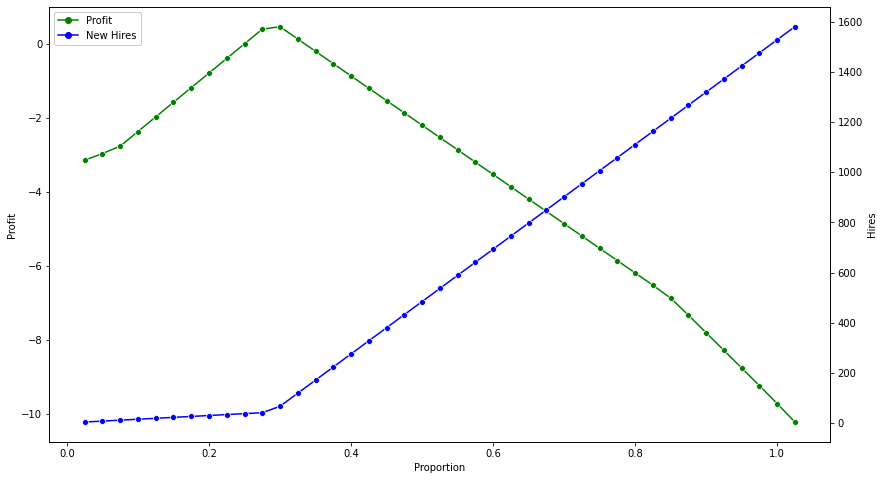

In [131]:
from matplotlib.lines import Line2D

plt.figure(figsize=(14,8))
g = sns.lineplot(data=dfFinal, x='Proportion', y='Profit', marker='o', color='g',)
sns.lineplot(data=dfFinal, x='Proportion', y='Hires', color='b', marker='o', ax=g.axes.twinx())
g.legend(handles=[Line2D([], [], marker='o', color='g', label='Profit'),
                  Line2D([], [], marker='o', color='b', label='New Hires')], 
         loc='upper left', fontsize='medium', framealpha=1)
plt.show()

### Centers E, F: To Open or To Remain Closed?

#### Case I: Maximizing Profits

In [132]:
def optimization_ef(e, f, prop):

  """
  Model 3 as a function.
  e: 0 -> Center E is closed, 1 -> Center E is open
  f: 0 -> Center F is closed, 1 -> Center F is open
  prop: proportion of demand to be met.
  """

  ############################################# Variables ##############################################

  # Variables: if a depot is opened/allocated
  yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

  # Variables: amount of demand from each zone allocated to depot, per scenario
  xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

  # Worker flow
  wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

  # New hires
  hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

  ######################################## Model Initialization ########################################

  # Initialize model and objective sense
  locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

  ############################################ Constraints #############################################

  # Balance of flow constraints

  for t in periods:

    for j in zones:
    # Contraint: demand must be satisfied in all scenarios
      locationModel += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) <= prop*zonedemand[(j,t)])

    for i in ['Center A', 'Center B', 'Center C', 'Center D']:
      locationModel += ( yvar[(i, 2021)] == 1 )
      locationModel += ( yvar[(i, t)] == 1 )
    
    for i in ['Center E']: 
      locationModel += ( yvar[(i, 2021)] == 0 )
      locationModel += ( yvar[(i, t)] == e )

    for i in ['Center F']: 
      locationModel += ( yvar[(i, 2021)] == 0 )
      locationModel += ( yvar[(i, t)] == f )

    for i in depots:
  
    # Constraint: depot capacities must be observed in all scenarios
      locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

    # Worker flow
      if t == 2022:
        locationModel += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_workers)

      numworkers = wvar[(i,t-1)] + hvar[(i,t)]
      locationModel += (wvar[(i,t)] == numworkers)

    # Capacity limited by workers
      locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= 250 * 6 * wvar[(i,t)]

    # Maximum number of hires
      locationModel += pulp.lpSum( hvar[(i,t)] ) <= 300

  ######################################### Objective Function #########################################

  # Objective function

  rate = 42 # amount reimbursed

  # Depot allocation costs
  obj = -( pulp.lpSum([ depotcost_opening[i] * yvar[(i,2024)] for i in depots] ) )

  for t in periods:

    # Revenue earned through reimbursement by the governement
    obj += pulp.lpSum( [ rate * xvar[(i,j,t)] for i in depots for j in zones ] )
    
    # Distance costs
    obj -= pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

    obj -= pulp.lpSum([ depotcost_operating[i] * yvar[(i,t)] for i in depots] )

    # Workers' pay
    obj -= pulp.lpSum( [ (37.85 * 250 * 6) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

    # Hiring costs
    obj -= pulp.lpSum( [ 15000 * hvar[(i,t)] for i in depots ] )

  # Add objective to model
  locationModel += obj

  ############################################## Results ###############################################

  locationModel.solve()
  print(prop, "| Status:", pulp.LpStatus[locationModel.status])

  total_profit = pulp.value(locationModel.objective)

  total_revenue = 0
  total_hires = 0
  for t in periods:
    for i in depots: 
      total_hires += hvar[(i,t)].varValue   
      for j in zones:
        total_revenue += (xvar[(i,j,t)].varValue)*42 

  profit = total_profit

  return round(profit, 2)/1e6, total_hires

E: Closed, F: Closed

In [133]:
optimization_ef(0,0,1)

1 | Status: Optimal


(4.72357875, 0.0)

E: Closed, F: Open

In [134]:
optimization_ef(0,1,1)

1 | Status: Optimal


(4.09857875, 0.0)

E: Open, F: Closed

In [135]:
optimization_ef(1,0,1)

1 | Status: Optimal


(4.09857875, 0.0)

E: Open, F: Open

In [136]:
optimization_ef(1,1,1)

1 | Status: Optimal


(3.47357875, 0.0)

#### Case II: Minimizing Costs - Meeting 100% Demand

In [137]:
def optimization_ef(e, f, prop):
  
  """
  Model 3 as a function.
  e: 0 -> Center E is closed, 1 -> Center E is open
  f: 0 -> Center F is closed, 1 -> Center F is open
  prop: proportion of demand to be met.
  """

  ############################################# Variables ##############################################

  # Variables: if a depot is opened/allocated
  yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

  # Variables: amount of demand from each zone allocated to depot, per scenario
  xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

  # Worker flow
  wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

  # New hires
  hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

  ######################################## Model Initialization ########################################

  # Initialize model and objective sense
  locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMinimize)

  ############################################ Constraints #############################################

  # Balance of flow constraints

  for t in periods:

    for j in zones:
    # Contraint: demand must be satisfied in all scenarios
      locationModel += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) == prop*zonedemand[(j,t)])

    for i in ['Center A', 'Center B', 'Center C', 'Center D']:
      locationModel += ( yvar[(i, 2021)] == 1 )
      locationModel += ( yvar[(i, t)] == 1 )
    
    for i in ['Center E']: 
      locationModel += ( yvar[(i, 2021)] == 0 )
      locationModel += ( yvar[(i, t)] == e )

    for i in ['Center F']: 
      locationModel += ( yvar[(i, 2021)] == 0 )
      locationModel += ( yvar[(i, t)] == f )

    for i in depots:
  
    # Constraint: depot capacities must be observed in all scenarios
      locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

    # Worker flow
      if t == 2022:
        locationModel += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_workers)

      numworkers = wvar[(i,t-1)] + hvar[(i,t)]
      locationModel += (wvar[(i,t)] == numworkers)

    # Capacity limited by workers
      locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= 250 * 6 * wvar[(i,t)]

    # Maximum number of hires
      locationModel += pulp.lpSum( hvar[(i,t)] ) <= 300

  ######################################### Objective Function #########################################

  # Objective function

  # Depot allocation costs
  obj = pulp.lpSum([ depotcost_opening[i] * yvar[(i,2024)] for i in depots] )

  for t in periods:
    
    # Distance costs
    obj += pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

    obj += pulp.lpSum([ depotcost_operating[i] * yvar[(i,t)] for i in depots] )

    # Workers' pay
    obj += pulp.lpSum( [ (37.85 * 250 * 6) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

    # Hiring costs
    obj += pulp.lpSum( [ 15000 * hvar[(i,t)] for i in depots ] )

  # Add objective to model
  locationModel += obj

  ############################################## Results ###############################################

  locationModel.solve()
  print(prop, "| Status:", pulp.LpStatus[locationModel.status])

  total_cost = pulp.value(locationModel.objective)

  total_revenue = 0
  total_hires = 0
  for t in periods:
    for i in depots: 
      total_hires += hvar[(i,t)].varValue   
      for j in zones:
        total_revenue += (xvar[(i,j,t)].varValue)*42 

  profit = total_revenue - total_cost

  return round(profit, 2)/1e6, total_hires

E: Closed, F: Closed

In [138]:
optimization_ef(0,0,1)

1 | Status: Infeasible


(-18.028717920000002, 1528.121333)

In [139]:
optimization_ef(0,0,0.905)

0.905 | Status: Optimal


(-15.2049105, 1329.749807)

E: Closed, F: Open

In [140]:
optimization_ef(0,1,1)

1 | Status: Optimal


(-17.424819489999997, 1528.121333)

E: Open, F: Closed

In [141]:
optimization_ef(1,0,1)

1 | Status: Optimal


(-9.723959449999999, 1528.121334)

E: Open, F: Open

In [142]:
optimization_ef(1,1,1)

1 | Status: Optimal


(-10.03066843, 1528.1213340000002)

### Demand: Robustness to Variation

In [143]:
profitDict = {'Proportion':[], 'Profit':[], 'Hires':[]}
for prop in np.arange(1, 2.05, 0.025):
  profitDict['Proportion'].append(prop)
  profit, total_hires = optimization(prop)
  profitDict['Profit'].append(profit)
  profitDict['Hires'].append(total_hires)

1.0 | Status: Optimal
1.025 | Status: Optimal
1.0499999999999998 | Status: Optimal
1.0749999999999997 | Status: Optimal
1.0999999999999996 | Status: Optimal
1.1249999999999996 | Status: Optimal
1.1499999999999995 | Status: Optimal
1.1749999999999994 | Status: Optimal
1.1999999999999993 | Status: Optimal
1.2249999999999992 | Status: Infeasible
1.2499999999999991 | Status: Infeasible
1.274999999999999 | Status: Infeasible
1.299999999999999 | Status: Infeasible
1.3249999999999988 | Status: Infeasible
1.3499999999999988 | Status: Infeasible
1.3749999999999987 | Status: Infeasible
1.3999999999999986 | Status: Infeasible
1.4249999999999985 | Status: Infeasible
1.4499999999999984 | Status: Infeasible
1.4749999999999983 | Status: Infeasible
1.4999999999999982 | Status: Infeasible
1.5249999999999981 | Status: Infeasible
1.549999999999998 | Status: Infeasible
1.574999999999998 | Status: Infeasible
1.5999999999999979 | Status: Infeasible
1.6249999999999978 | Status: Infeasible
1.6499999999999977 

In [144]:
dfFinal = pd.DataFrame(profitDict) 
dfFinal.sort_values(by='Proportion', ascending=True)

,Proportion,Profit,Hires
0,1.000,-9.723959,1528.121334
1,1.025,-10.223036,1580.324366
2,1.050,-10.730221,1632.527400
3,1.075,-11.424466,1684.730436
4,1.100,-12.098108,1736.933466
5,1.125,-12.920259,1789.136500
6,1.150,-13.776260,1841.339534
7,1.175,-14.632260,1893.542566
8,1.200,-15.488262,1945.745600
9,1.225,-15.249728,1997.948634


### Health Professionals

#### Negotiate Wage

In [145]:
def optimization_worker(wage=37.85, hiring_cost=15000, days=250, hour=6):
  
  """
  Model 3 as a function.
  wage: hourly wage of a health professional
  hiring_cost: one-time costs associated with a new health professional
  days: number of working days for a health professional in a year
  hour: average working hours in a day for a health professional
  """

  ############################################# Variables ##############################################

  # Variables: if a depot is opened/allocated
  yvar = pulp.LpVariable.dict("y", (depots, [2021]+periods), cat=pulp.LpBinary)

  # Variables: amount of demand from each zone allocated to depot, per scenario
  xvar = pulp.LpVariable.dict("x", (depots, zones, periods), lowBound=0.0, cat=pulp.LpContinuous)

  # Worker flow
  wvar = pulp.LpVariable.dict("w", (depots, [2021]+periods), lowBound=0, cat=pulp.LpContinuous)

  # New hires
  hvar = pulp.LpVariable.dict("h", (depots, periods), lowBound=0, cat=pulp.LpContinuous)

  ######################################## Model Initialization ########################################

  # Initialize model and objective sense
  locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMinimize)

  ############################################ Constraints #############################################

  # Balance of flow constraints

  for t in periods:

    for j in zones:
    # Contraint: demand must be satisfied in all scenarios
      locationModel += (pulp.lpSum( [xvar[(i,j,t)] for i in depots] ) == zonedemand[(j,t)])

    for i in ['Center A', 'Center B', 'Center C', 'Center D']:
      locationModel += ( yvar[(i, 2021)] == 1 )
      locationModel += ( yvar[(i, t)] == 1 )
    
    for i in ['Center E', 'Center F']: 
      locationModel += ( yvar[(i, 2021)] == 0 )
      locationModel += ( yvar[(i, t)] >= yvar[(i, t-1)] )

    for i in depots:
  
    # Constraint: depot capacities must be observed in all scenarios
      locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= depotcapacity[i] * yvar[(i,t)]

    # Worker flow
      if t == 2022:
        locationModel += pulp.lpSum( [ wvar[(i,t-1)] for i in depots ] ) <= (total_workers)

      numworkers = wvar[(i,t-1)] + hvar[(i,t)]
      locationModel += (wvar[(i,t)] == numworkers)

    # Capacity limited by workers
      locationModel += pulp.lpSum( [xvar[(i,j,t)] for j in zones] ) <= days * hour * wvar[(i,t)]

    # Maximum number of hires
      locationModel += pulp.lpSum( hvar[(i,t)] ) <= 300

  ######################################### Objective Function #########################################

  # Objective function

  # Depot allocation costs
  obj = pulp.lpSum([ depotcost_opening[i] * yvar[(i,2024)] for i in depots] )

  for t in periods:
    
    # Distance costs
    obj += pulp.lpSum( [ depotzonecost[(i,j)] * xvar[(i,j,t)] for i in depots for j in zones ] )

    obj += pulp.lpSum([ depotcost_operating[i] * yvar[(i,t)] for i in depots] )

    # Workers' pay
    obj += pulp.lpSum( [ (wage * days * hour) * (1.025**(t-2022)) * wvar[(i,t)] for i in depots ] )

    # Hiring costs
    obj += pulp.lpSum( [ hiring_cost * hvar[(i,t)] for i in depots ] )

  # Add objective to model
  locationModel += obj

  ############################################## Results ###############################################

  locationModel.solve()
  print("Status:", pulp.LpStatus[locationModel.status])

  total_cost = pulp.value(locationModel.objective)

  total_revenue = 0
  total_hires = 0
  for t in periods:
    for i in depots: 
      total_hires += hvar[(i,t)].varValue   
      for j in zones:
        total_revenue += (xvar[(i,j,t)].varValue)*42 

  profit = total_revenue - total_cost

  return round(profit, 2)/1e6

In [146]:
profitDict = {'Wage':[], 'Profit':[]}
wage = 37.85
for w in np.arange(0.75, 1.25, 0.05)*wage:
  profitDict['Wage'].append(w)
  profit = optimization_worker(wage=w)
  profitDict['Profit'].append(profit)

dfFinal = pd.DataFrame(profitDict) 
dfFinal

Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal


,Wage,Profit
0,28.3875,78.237768
1,30.2800,60.645422
2,32.1725,43.053077
3,34.0650,25.460731
4,35.9575,7.868386
5,37.8500,-9.723959
6,39.7425,-27.316305
7,41.6350,-44.908650
8,43.5275,-62.500996
9,45.4200,-80.093341


#### Varying Hiring Costs

In [147]:
profitDict = {'Hiring Cost':[], 'Profit':[]}
hiring_cost = 15000
for hc in np.arange(0.50, 1.5, 0.05)*hiring_cost:
  profitDict['Hiring Cost'].append(hc)
  profit = optimization_worker(hiring_cost=hc)
  profitDict['Profit'].append(profit)

dfFinal = pd.DataFrame(profitDict) 
dfFinal

Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal


,Hiring Cost,Profit
0,7500.0,1.736951
1,8250.0,0.590860
2,9000.0,-0.555231
3,9750.0,-1.701322
4,10500.0,-2.847413
5,11250.0,-3.993504
6,12000.0,-5.139595
7,12750.0,-6.285686
8,13500.0,-7.431777
9,14250.0,-8.577868


#### Negotiate Working Days

In [148]:
profitDict = {'Days':[], 'Profit':[]}
for d in np.arange(250, 275, 1):
  profitDict['Days'].append(d)
  profit = optimization_worker(days=d)
  profitDict['Profit'].append(profit)

dfFinal = pd.DataFrame(profitDict) 
dfFinal

Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal


,Days,Profit
0,250,-9.723959
1,251,-9.578225
2,252,-9.433482
3,253,-9.289715
4,254,-9.146915
5,255,-9.005074
6,256,-8.864175
7,257,-8.724210
8,258,-8.586410
9,259,-8.449758


#### Negotiate Working Hours

In [149]:
profitDict = {'Hours':[], 'Profit':[]}
for d in np.arange(6, 10, 0.5):
  profitDict['Hours'].append(d)
  profit = optimization_worker(hour=d)
  profitDict['Profit'].append(profit)

dfFinal = pd.DataFrame(profitDict) 
dfFinal

Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal
Status: Optimal


,Hours,Profit
0,6.0,-9.723959
1,6.5,-6.898386
2,7.0,-4.432739
3,7.5,-2.591055
4,8.0,-1.024964
5,8.5,0.356882
6,9.0,1.585188
7,9.5,2.684198
